## NLP for disaster management (Flooding)

The purpose of this notebook is to act as a development environment for the FDL floods project. 

The project as completed by the ESA team surrounds the use of image data to create flood segmentation models which can be applied on a Movidius neural network stick.

Given the use of image data in this case we have made the decision to approach the problem of disaster management another way namely through the use of natural language processing to bucket tweets into categories so that they can be queried by individuals on the ground 

### Loading appropriate scripts

In [1]:
\l nlp/init.q
\l ml/ml.q
\l ../code/fdl_disasters.q
.ml.loadfile`:init.q

### Loading required python Functionality

In [3]:
npa:.p.import[`numpy]`:array
plt:.p.import[`matplotlib.pyplot]
pd :.p.import[`pandas]

// Textual data preprocessing 
token:.p.import[`keras.preprocessing.text]`:Tokenizer
pad  :.p.import[`keras.preprocessing.sequence]`:pad_sequences

kl:{.p.import[`keras.layers]x}
// Keras layers used
seq    :.p.import[`keras.models]`:Sequential
dense  :kl`:Dense
embed  :kl`:Embedding
lstm   :kl`:LSTM
spdrop1:kl`:SpatialDropout1D
dropout:kl`:Dropout

### Data loading and preprocessing 

In [4]:
nms_1:{rename[;names]("j*SSS";enlist",")0:`$":../data/floods/",x}
nms_2:{("jSSIPSf*J*S";enlist",")0:`$":../data/floods/",x}

In [5]:
/ Colorado
co :nms_1["Developed/2013_Colorado_floods/2013_Colorado_floods-tweets_labeled.csv"]
/ Queensland
qld:nms_1["Developed/2013_Queensland_floods/2013_Queensland_floods-tweets_labeled.csv"]
/ Alberta
alb:nms_1["Developed/2013_Alberta_floods/2013_Alberta_floods-tweets_labeled.csv"]
/ Phillipines
ph :nms_1["Developing/2012_Philipinnes_floods/2012_Philipinnes_floods-tweets_labeled.csv"]
/ India
ind:nms_2["Developing/2014_India_floods/2014_india_floods.csv"]
/ Pakistan
pac:nms_2["Developing/2014_Pakistan_floods/2014_pakistan_floods.csv"]

In [6]:
// Label consolidation and joining of different format data
data_b:encodetgt[co,qld,alb,ph;encodebin],encodetgt[ind,pac;encodebin]
data_m:encodetgt[co,qld,alb,ph;encodemulti],encodetgt[ind,pac;encodemulti]
// Remove capitalization
data_m[`tweet_text]:data_b[`tweet_text]:lower data_m`tweet_text
// remove data from set which is missing labels
inds:exec i from data_m where target<>`not_labeled
data_b:data_b@inds
data_m:data_m@inds

In [7]:
// Textual data cleansing
rmv_list   :("http*";"rt";"@*";"*,";"*&*";"*[0-9]*")
rmv_single :rmv_master[;",.:?!/@'";""]
rmv_hashtag:rmv_master[;"#";""]

In [8]:
5#data_m`tweet_text

"rt @dlfluegge: crazy flooding in boulder, colorado http://t.co/sg0iidqcey vi..
"here's the #boulderflood video that's circulating around. right in my old ne..
"rt @passantino: video: severe flooding hits near univ. of colorado at boulde..
"crazy flooding in boulder, colorado http://t.co/3igoyaafwe"
"thoughts and prayers out to those in boulder who may not get to amante for m..


In [9]:
// Remove non ascii, retweet tag, numerical values, emojis and space hashtags 
data_m[`tweet_text]:data_b[`tweet_text]:
 (rmv_ascii rmv_custom[;rmv_list] rmv_hashtag rmv_single@) each data_m`tweet_text


In [10]:
5#data_m`tweet_text

"dlfluegge crazy flooding in boulder colorado via youtube"
"heres the boulderflood video thats circulating around right in my old neighb..
"passantino video severe flooding hits near univ of colorado at boulder"
"crazy flooding in boulder colorado"
"thoughts and prayers out to those in boulder who may not get to amante for m..


---

## Initial data analysis steps

The purpose of this section is to take a high level look at the data both in regards to the distribution of classes, explore what underlays the classes themselves and perform some rudimentary sentiment analysis on the data to find positive and negative tweets

---

### Word cloud analysis

In the following cells we display the most commonly associated words with a number of the classes within this dataset

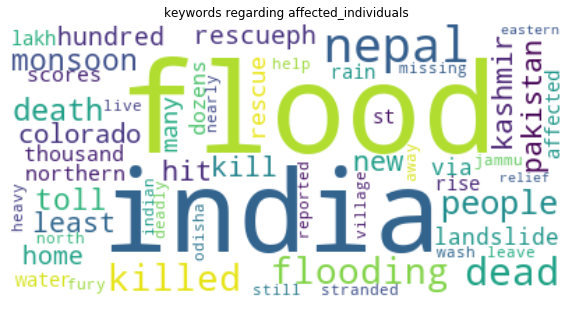

In [11]:
wordcloudfn[data_m;`affected_individuals]

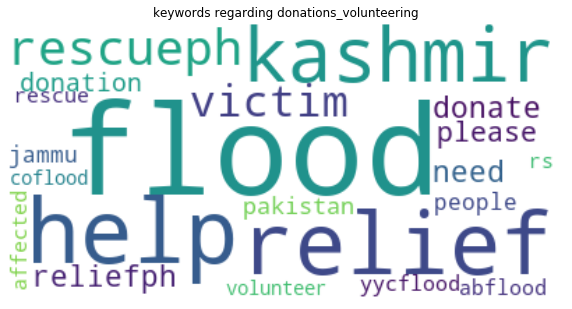

In [12]:
wordcloudfn[data_m;`donations_volunteering]

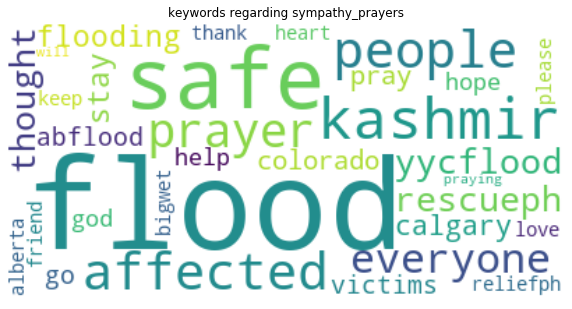

In [38]:
wordcloudfn[data_m;`sympathy_prayers]

Given the context of the tweets that within the overall dataset it is not surprising that words such as flood and locations such as Pakistan and Kashmir are displayed within a number of the classes. However some displayed words are more informative to the classes,

* donations_volunteering:
    - affected, donate, rescue, volunteer, people
* affected_individuals:
    - killed, dead, affected, missing, toll
* sympathy_prayers:
    - pray, safe, friend, thought, love
    
The presence of distinct words within each class lends credence to the idea that it should be possible to classify these tweets into their associated categories and generalise this method to new and larger datasets

---

### Sentiment analysis

The following cells outline the use of the Kx NLP library to discern positive and negative sentiments from tweets within the corpus. Below we are displaying 5 of the 100 most positive and most negative tweets in the dataset.

This allows us to gain some understanding of the state of mind of those individuals affected by the crises

In [13]:
// compute the sentiment of the tweets within the corpus
sentiments:.nlp.sentiment each data_m`tweet_text
\c 200 200
5?100#data_m[`tweet_text] iasc  sentiments`compound
5?100#data_m[`tweet_text] idesc sentiments`compound
\c 20 90

"havoc death destruction due floods in up bihar assam unacceptable after yrs of independence india needs a credible solution"
"hundreds dead as monsoon brings chaos to northern india nepal (cnn)  dozens of people have been killed in"
"flood fury in north india dozens killed lakhs affected - ndtv ndtvflood fury in north india dozens killed"
"bihar of a family killed as train hits auto - hindustan times times of indiabihar of a family killed"
"rapejihad in up continues faizabadgangrape year old hindu girl gang raped and killed hdlindiaorg"


"major_amkhan proudly serving pakistan satisfaction while helping your countrymen at the time of need help the flood victims"
"calgarypolice thank you yyc for the kind compliments this evening they will help us go through the night yycflood"
"major_amkhan proudly serving pakistan satisfaction while helping your countrymen at the time of need help the flood victims"
"joeybonifacio im encouraging those who can to help with our relief work at victoryfort tomorrow at rescueph"
"davidhurley_cdf adf is doing a great job working alongside the qld community to clean up after the flood keep up the good work"


---

### Category distribution metrics

One important aspect of training machine learning models is an understanding of the distributions of categories within the datasets. This provides a pseudo benchmark from which we can assess the ability of the models to correctly categorize differing classes.

For example in an extremely skewed binary classification model with one class `1b` comprising 95% of the target labels a model which has an accuracy on the order of 95% would not be said to have 'learnt' how to distinguish the classes as guessing that all data was labeled `1b` it would achieve this accuracy.

As a result we look at other metrics to assess the model performance such as precision, recall and f1-score which are discussed within the whitepaper which details this work from a theoretical viewpoint

##### Binary Classification 

In [14]:
distrib_b:desc count each group data_b`target

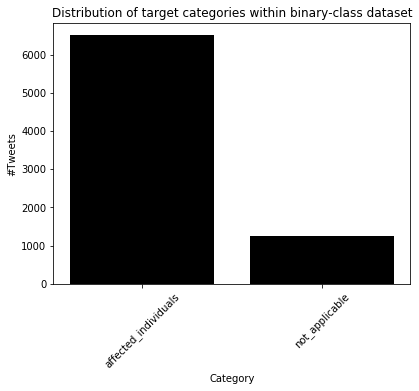

In [15]:
plt[`:bar][til count distrib_b;value distrib_b;`color pykw `k];
plt[`:title][`$"Distribution of target categories within binary-class dataset"];
plt[`:xlabel][`Category];
plt[`:xticks][til count distrib_b;key distrib_b;`rotation pykw `45];
plt[`:ylabel][`$"#Tweets"];
plt[`:show][];

##### Multi-label Classification

In [16]:
distrib_m:desc count each group data_m`target

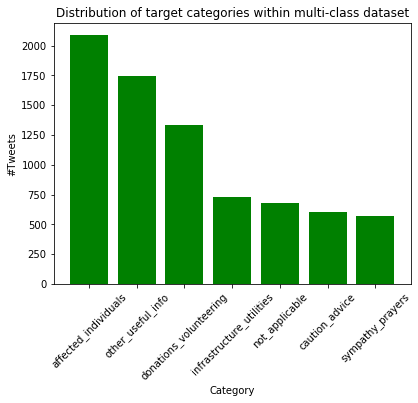

In [17]:
plt[`:bar][til count distrib_m;value distrib_m;`color pykw `g];
plt[`:title][`$"Distribution of target categories within multi-class dataset"];
plt[`:xlabel][`Category];
plt[`:xticks][til count distrib_m;key distrib_m;`rotation pykw `45];
plt[`:ylabel][`$"#Tweets"];
plt[`:show][];

---

### Model Binary-Class Disaster Management

In [18]:
batch_sz    :64
embed_dim   :100
epochs      :10
max_nb_words:2000
max_seq_len :50

In [19]:
py_data_b :npa data_b`tweet_text
tweet_vals:py_data_b

In [20]:
tokenizer:token[`num_words pykw max_nb_words;`lower pykw 1b]
tokenizer[`:fit_on_texts]tweet_vals;

In [21]:
X_b:tokenizer[`:texts_to_sequences]tweet_vals
X_b:pad[X_b;`maxlen pykw max_seq_len]`

Y_b:flip value ohe:.ml.i.onehot1 data_b`target

In [22]:
tts_b:.ml.traintestsplit[X_b;Y_b;0.1]
xtrn_b:tts_b`xtrain;ytrn_b:tts_b`ytrain
xtst_b:tts_b`xtest;ytst_b:tts_b`ytest

In [24]:
mdl_b:seq[];
mdl_b[`:add][embed[max_nb_words;embed_dim;`input_length pykw (.ml.shape X_b)1]];
mdl_b[`:add]spdrop1[0.2];
mdl_b[`:add]lstm[50;pykwargs `dropout`recurrent_dropout!(0.2;0.2)];
mdl_b[`:add]dense[2;`activation pykw `softmax];
mdl_b[`:compile][pykwargs `loss`optimizer`metrics!(`categorical_crossentropy;`adam;enlist `accuracy)];
print mdl_b[`:summary][];

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 230,302
Trainable params: 230,302
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
strt:.z.t
mdl_b[`:fit][npa xtrn_b;npa ytrn_b;`epochs pykw epochs;`verbose pykw 0];
-1"\nTraining time = ",string .z.t-strt;

W0808 18:39:53.205224 139812113477632 deprecation.py:323] From /home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0808 18:39:53.788195 139812113477632 deprecation_wrapper.py:119] From /home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:949: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0808 18:39:53.795405 139812113477632 deprecation.py:506] From /home/cmccarthy/anaconda3/envs/newq/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:671: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer insta


Training time = 00:01:38.448


In [26]:
class_scoring[xtst_b;ytst_b;mdl_b;ohe]


The following is the integer mapping between class integer representation and real class value:

affected_individuals| 0
not_applicable      | 1

Actual Class vs prediction

Class Prediction Hit
--------------------
0     1          0  
0     0          1  
1     1          1  
0     0          1  
0     0          1  

Displaying percentage of Correct prediction vs misses per class:

Class| Hit       Miss      
-----| --------------------
0    | 0.934033  0.06596702
1    | 0.6851852 0.3148148 
TOTAL| 0.8993548 0.1006452 

Displaying predicted vs actual class assignment matrix:

Class| Pred_0 Pred_1
-----| -------------
0    | 623    44    
1    | 34     74    

Classification report showing precision, recall and f1-score for each class:



class               | precision recall    f1_score  support
--------------------| -------------------------------------
affected_individuals| 0.9482496 0.934033  0.9410876 667    
not_applicable      | 0.6271186 0.6851852 0.6548673 108    
avg/total           | 0.7876841 0.8096091 0.7979774 775    


### Model Multi-Class Disaster Management

In [27]:
py_data_m :npa data_b`tweet_text
tweet_vals:py_data_m
tokenizer:token[`num_words pykw max_nb_words;`lower pykw 1b]
tokenizer[`:fit_on_texts][tweet_vals];

In [28]:
X_m:tokenizer[`:texts_to_sequences]tweet_vals
X_m:pad[X_m;`maxlen pykw max_seq_len]`

Y_m:flip value ohe:.ml.i.onehot1 data_m`target

In [29]:
tts_m:.ml.traintestsplit[X_m;Y_m;0.1]
xtrn_m:tts_m`xtrain;ytrn_m:tts_m`ytrain
xtst_m:tts_m`xtest;ytst_m:tts_m`ytest

In [30]:
mdl_m:seq[];
mdl_m[`:add][embed[max_nb_words;embed_dim;`input_length pykw (.ml.shape X_m)1]];
mdl_m[`:add]spdrop1[0.1];
mdl_m[`:add]lstm[100;pykwargs `dropout`recurrent_dropout!(0.1;0.1)];
mdl_m[`:add]dense[7;`activation pykw `softmax];
mdl_m[`:compile][pykwargs `loss`optimizer`metrics!(`categorical_crossentropy;`adam;enlist `accuracy)];
print mdl_m[`:summary][];

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 281,107
Trainable params: 281,107
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
strt:.z.t
mdl_m[`:fit][npa xtrn_m;npa ytrn_m;`epochs pykw epochs;`verbose pykw 0];
-1"\nTraining time = ",string .z.t-strt;


Training time = 00:01:35.550


In [32]:
class_scoring[xtst_m;ytst_m;mdl_m;ohe]


The following is the integer mapping between class integer representation and real class value:

affected_individuals    | 0
caution_advice          | 1
donations_volunteering  | 2
infrastructure_utilities| 3
not_applicable          | 4
other_useful_info       | 5
sympathy_prayers        | 6

Actual Class vs prediction

Class Prediction Hit
--------------------
0     0          1  
2     2          1  
2     0          0  
4     4          1  
5     3          0  

Displaying percentage of Correct prediction vs misses per class:

Class| Hit       Miss     
-----| -------------------
0    | 0.8504673 0.1495327
1    | 0.515625  0.484375 
2    | 0.7121212 0.2878788
3    | 0.4878049 0.5121951
4    | 0.637931  0.362069 
5    | 0.6432749 0.3567251
6    | 0.5740741 0.4259259
TOTAL| 0.68      0.32     

Displaying predicted vs actual class assignment matrix:

Class| Pred_0 Pred_1 Pred_2 Pred_3 Pred_4 Pred_5 Pred_6
-----| ------------------------------------------------
0    | 182    5      9 

class                   | precision recall    f1_score  support
------------------------| -------------------------------------
affected_individuals    | 0.8310502 0.8504673 0.8406467 214    
caution_advice          | 0.4852941 0.515625  0.5       64     
donations_volunteering  | 0.7230769 0.7121212 0.7175573 132    
infrastructure_utilities| 0.6451613 0.4878049 0.5555556 82     
not_applicable          | 0.74      0.637931  0.6851852 58     
other_useful_info       | 0.5555556 0.6432749 0.596206  171    
sympathy_prayers        | 0.6458333 0.5740741 0.6078431 54     
avg/total               | 0.6608531 0.631614  0.6432848 775    


---

### Balanced classes

Looking at the distribution of classes within the main dataset it is clear that the classes are imbalanced. To reduce biases which may exist as a result of this imbalance a balanced dataset was built and a model fit with the 'improved model' in order to test improvements that could be gained from the use of a more balanced dataset

In [33]:
inds_m:raze{neg[x]?y}[min count each l]each value l:group data_m`target
bal_X_m:X_m@inds_m
bal_Y_m:Y_m@inds_m

In [34]:
bal_tts_m:.ml.traintestsplit[bal_X_m;bal_Y_m;0.1]
xtrn_m:bal_tts_m`xtrain;ytrn_m:bal_tts_m`ytrain
xtst_m:bal_tts_m`xtest;ytst_m:bal_tts_m`ytest

In [35]:
bal_mdl_m:seq[];
bal_mdl_m[`:add][embed[max_nb_words;embed_dim;`input_length pykw (.ml.shape X_m)1]];
bal_mdl_m[`:add]spdrop1[0.1];
bal_mdl_m[`:add]lstm[100;pykwargs `dropout`recurrent_dropout!(0.1;0.1)];
bal_mdl_m[`:add]dense[7;`activation pykw `softmax];
bal_mdl_m[`:compile][pykwargs `loss`optimizer`metrics!(`categorical_crossentropy;`adam;enlist `accuracy)];
print bal_mdl_m[`:summary][];

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 707       
Total params: 281,107
Trainable params: 281,107
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
strt:.z.t
bal_mdl_m[`:fit][npa xtrn_m;npa ytrn_m;`epochs pykw epochs;`verbose pykw 0];
-1"\nTraining time = ",string .z.t-strt;


Training time = 00:00:50.095


In [37]:
class_scoring[xtst_m;ytst_m;bal_mdl_m;ohe]


The following is the integer mapping between class integer representation and real class value:

affected_individuals    | 0
caution_advice          | 1
donations_volunteering  | 2
infrastructure_utilities| 3
not_applicable          | 4
other_useful_info       | 5
sympathy_prayers        | 6

Actual Class vs prediction

Class Prediction Hit
--------------------
2     5          0  
4     0          0  
5     1          0  
5     5          1  
0     0          1  

Displaying percentage of Correct prediction vs misses per class:

Class| Hit       Miss     
-----| -------------------
0    | 0.7323944 0.2676056
1    | 0.453125  0.546875 
2    | 0.6923077 0.3076923
3    | 0.52      0.48     
4    | 0.7358491 0.2641509
5    | 0.6136364 0.3863636
6    | 0.5714286 0.4285714
TOTAL| 0.6171285 0.3828715

Displaying predicted vs actual class assignment matrix:

Class| Pred_0 Pred_1 Pred_2 Pred_3 Pred_4 Pred_5 Pred_6
-----| ------------------------------------------------
0    | 52     3      4 

class                   | precision recall    f1_score  support
------------------------| -------------------------------------
affected_individuals    | 0.8813559 0.7323944 0.8       71     
caution_advice          | 0.58      0.453125  0.5087719 64     
donations_volunteering  | 0.72      0.6923077 0.7058824 52     
infrastructure_utilities| 0.4193548 0.52      0.4642857 50     
not_applicable          | 0.65      0.7358491 0.6902655 53     
other_useful_info       | 0.3913043 0.6136364 0.4778761 44     
sympathy_prayers        | 0.7659574 0.5714286 0.6545455 63     
avg/total               | 0.6297104 0.616963  0.6145181 397    


---